### Semantic features as word embeddings

In [1]:
import numpy as np
import os
import torch

### fMRI data

In [5]:
# https://www.typingmaster.com/speech-speed-test/#:~:text=The%20average%20Speaking%20Speed%20Rate,of%20words%20in%20your%20speech.
seconds = 2
AVG_WORDS_PER_SEC = 2.5
AVG_TOKENS_PER_WORD = 5
context_length = int(seconds * AVG_WORDS_PER_SEC)
bert_max_tokens = AVG_TOKENS_PER_WORD * context_length

In [6]:
def get_continuous_word_activations(path, context_len = 17):
    """
        Returns dataset of fMRI word activations
        path            Path to .txt fMRI data vectors (continuous) from Cognival
        context_len     Words before the occurring one
        data            Returned dictionary with key ['word'] -> {'context', 'activations'}
    """
    data = {}
    context = []
    with open(path, "r") as datafile:
        lines = datafile.readlines()[1:] # skip header
        for line in lines:
            word = line.split(" ")[0]
            activations = np.array([float(x) for x in line.split(" ")[1:]])
            data[word] = {"context": context[-context_len:], "activations": activations}
            context.append(word)
    return data

In [7]:
subject = 1
voxels = 1000
filename = os.path.join("data", "cognival", "fmri", "harry-potter", f"{voxels}-random-voxels", f"scaled_{voxels}_wehbe_targets_{subject}.txt")
fmriData = get_continuous_word_activations(filename, context_length)

### BERT embeddings

In [8]:
import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")

def get_word_BERT_embed(word, layer=0, max_tokens=50):
    """
        Returns a stacked contextual word embedding from n-th BERT layer 
        word            Entry from the Cognival dataset
        layer           Index of the layer from which to extract activations (0 = last)
        max_tokens      Padding size, max tokens in sentence
    """
    text = " ".join(word[1]["context"] + [word[0]])

    encoded_input = tokenizer(text, return_tensors='pt', padding="max_length", max_length=max_tokens)
    output = model(**encoded_input, output_hidden_states=True)
    attention_hidden_states = output.hidden_states[1:]

    # Stacking
    # layer_hidden_states = attention_hidden_states[layer-1].flatten()
    # layer_hidden_states / layer_hidden_states.norm(dim=-1, keepdim=True)

    # Average
    layer_hidden_states = attention_hidden_states[layer-1][0].mean(dim=0)
    return layer_hidden_states.detach().cpu().numpy()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Predicting

In [9]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [10]:
# Building train set
X1 = list(fmriData.items())
X = []
for word in tqdm(X1):
    X.append(get_word_BERT_embed(word, max_tokens=bert_max_tokens))

# Fetch fMRI activations from the dataset
X = np.array(X)
Y = np.array([word[1]["activations"] for word in X1])

100%|██████████| 1295/1295 [00:46<00:00, 27.69it/s]


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.01, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1282, 768) (13, 768)
(1282, 1000) (13, 1000)


In [12]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neural_network import MLPRegressor

# make_pipeline(StandardScaler(with_mean=False), LinearRegression())
predictors = [LinearRegression(n_jobs=16) for i in range(voxels)]
scores = []

# One predictor per voxel
i = 0
for model in tqdm(predictors):
    model.fit(X_train, y_train[:, i])
    scores.append(model.score(X_test, y_test[:, i]))
    i += 1

scores = np.array(scores)

100%|██████████| 1000/1000 [08:40<00:00,  1.92it/s]


In [13]:
# Picking the best 100 predictors per voxel
K = 100
ind = np.argpartition(scores, -K)[-K:]

print("min \t\t max \t\t mean")
print(f"{np.min(scores[ind]):.4f} \t\t {np.max(scores[ind]):.4f} \t {np.mean(scores[ind]):.4f}")

min 		 max 		 mean
-0.0241 		 0.7427 	 0.1982


Test RDMs R^2:	PearsonRResult(statistic=-0.021812824526617636, pvalue=4.0563555347057616e-172)


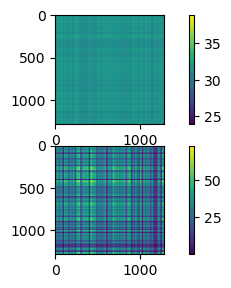

In [16]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def best_K_predict(X, indices, predictors):
    predictors = [predictors[idx] for idx in indices]
    y_hat = np.array([predictor.predict(X) for predictor in predictors]) # voxels, sample
    return y_hat.reshape(y_hat.shape[1], y_hat.shape[0]) # sample, voxels


y_hat = best_K_predict(X_train, ind, predictors)
y = y_train[:, ind]

RDM_hat = np.matmul(y_hat, np.matrix.transpose(y_hat))
# RDM_hat = (RDM_hat - RDM_hat.min()) / (RDM_hat.max() - RDM_hat.min())

RDM = np.matmul(y, np.matrix.transpose(y))
# RDM = (RDM - RDM.min()) / (RDM.max() - RDM.min())

test_pearson = pearsonr(
    RDM_hat.flatten(),
    RDM.flatten()
)

print(f"Test RDMs R^2:\t{test_pearson}")

plt.subplot(311)
plt.imshow(RDM)
plt.colorbar()

plt.subplot(312)
plt.imshow(RDM_hat)
plt.colorbar()